In [36]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Loading images from GDrive and creating directory per class
COV_DIR = "/content/drive/My Drive/covid/"
NORM_DIR = "/content/drive/My Drive/normal/"
VIR_DIR = "/content/drive/My Drive/virus/"

In [39]:
def Images_details_Print_data(data, path):
  print("===== Images in: ", path)
  for k, v in data.items():
    print("%s: \t%s" % (k, v))

# function for getting image specification details
def Image_details(path):
  files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
  data = {}
  data['images_count'] = len(files)
  data['min_width'] = 10**100 #no image will be bigger than that
  data['max_width'] = 0
  data['min_height'] = 10**100 #same
  data['max_height'] = 0

  for f in files:
    im = Image.open(f)
    width, height = im.size
    data['min_width'] = min(width, data['min_width'])
    data['max_width'] = max(width, data['max_width'])
    data['min_height'] = min(height, data['min_height'])
    data['max_height'] = max(height, data['min_height'])

  Images_details_Print_data(data, path)

In [40]:
Image_details(NORM_DIR)

===== Images in:  /content/drive/My Drive/normal/
images_count: 	672
min_width: 	1040
max_width: 	2890
min_height: 	650
max_height: 	1920


In [41]:
Cimages = os.listdir(COV_DIR)
Nimages = os.listdir(NORM_DIR)
Vimages = os.listdir(VIR_DIR)

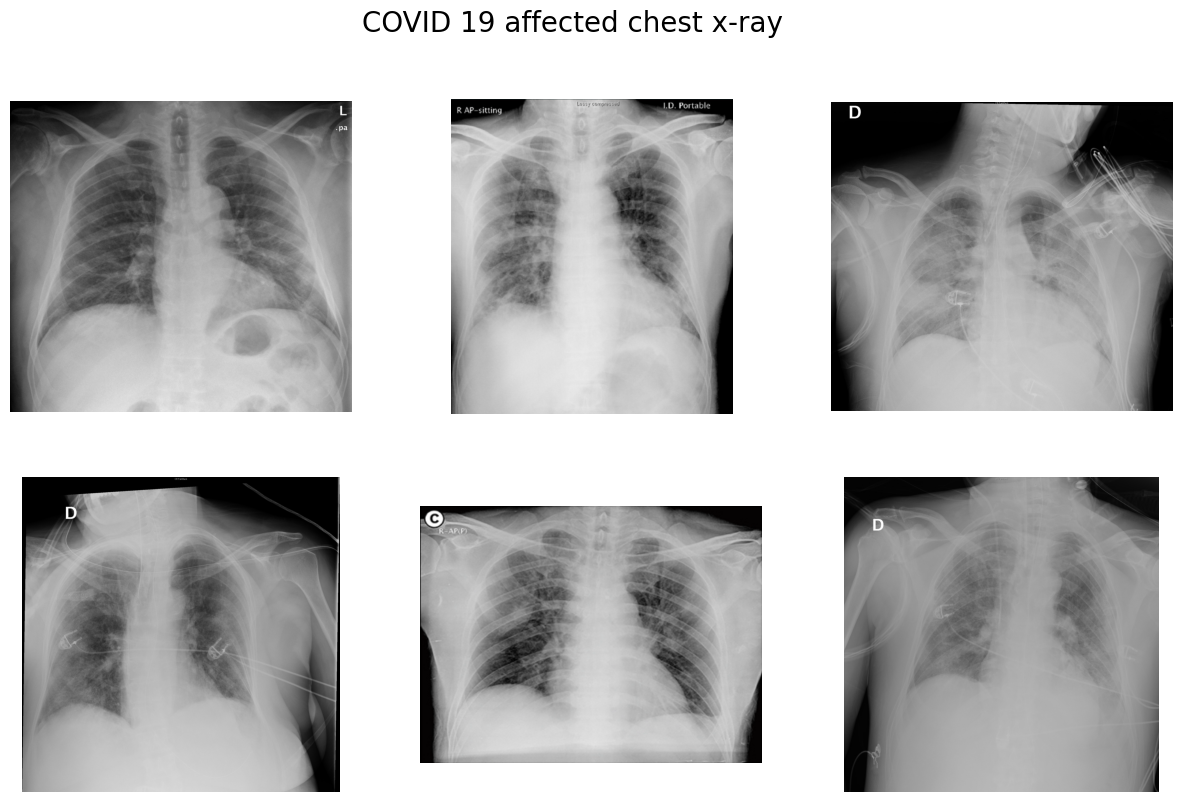

In [42]:
# plotting sample images of covid 19
sample_images = random.sample(Cimages, 6)
f, ax = plt.subplots(2, 3, figsize = (15, 9))

for i in range(0, 6):
  im = cv2.imread("/content/drive/My Drive/covid/" + sample_images[i])
  ax[i//3, i%3].imshow(im)
  ax[i//3, i%3].axis('off')

f.suptitle('COVID 19 affected chest x-ray', fontsize = 20)
plt.show()

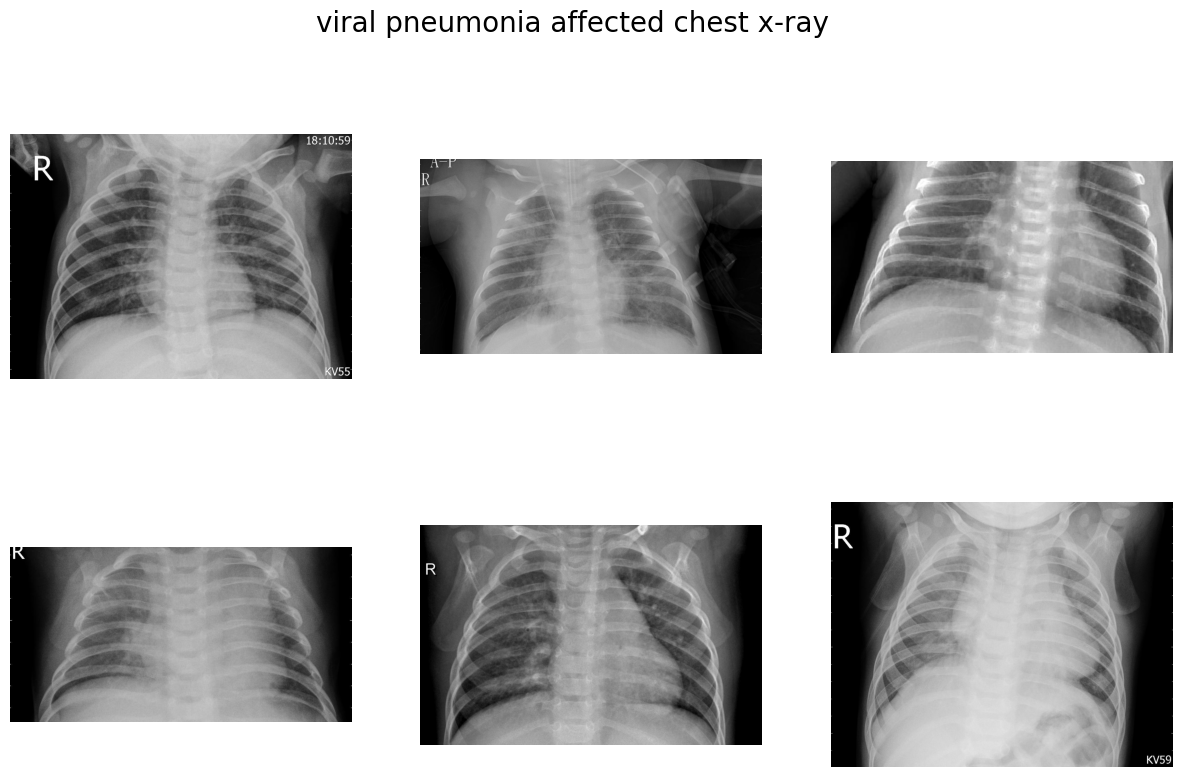

In [43]:
sample_images = random.sample(Vimages, 6)
f, ax = plt.subplots(2, 3, figsize = (15, 9))

for i in range(0, 6):
  im = cv2.imread("/content/drive/My Drive/virus/" + sample_images[i])
  ax[i//3, i%3].imshow(im)
  ax[i//3, i%3].axis('off')

f.suptitle('viral pneumonia affected chest x-ray', fontsize = 20)
plt.show()

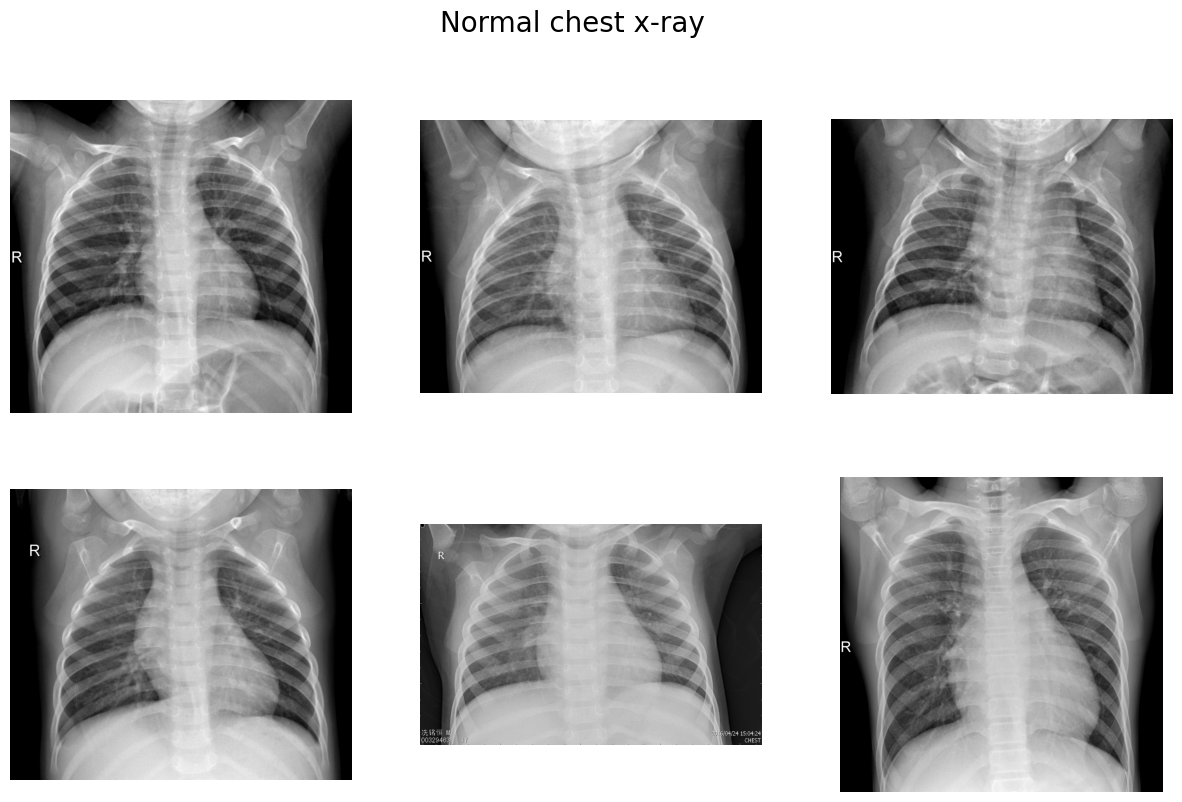

In [44]:
sample_images = random.sample(Nimages, 6)
f, ax = plt.subplots(2, 3, figsize = (15, 9))

for i in range(0, 6):
  im = cv2.imread("/content/drive/My Drive/normal/" + sample_images[i])
  ax[i//3, i%3].imshow(im)
  ax[i//3, i%3].axis('off')

f.suptitle('Normal chest x-ray', fontsize = 20)
plt.show()

# Image Preprocessing

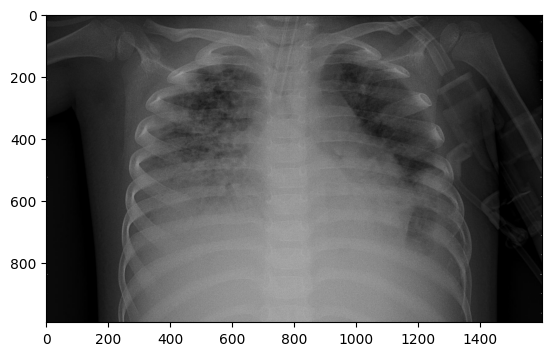

In [45]:
img = cv2.imread('/content/drive/My Drive/virus/person1661_virus_2872.jpeg')
plt.imshow(img, cmap=plt.cm.bone)

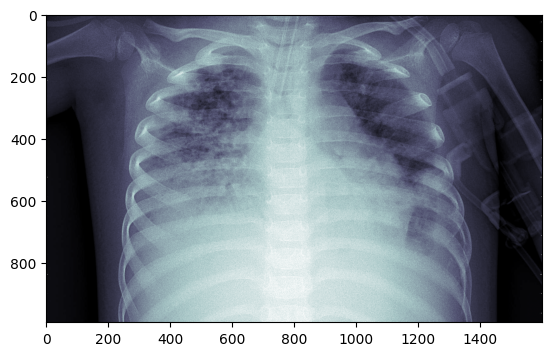

In [46]:
# White balance for every channel independently
def wb(channel, prec = 0.05):
  mi, ma = (np.percentile(channel, prec), np.percentile(channel, 100.0-prec))
  channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
  return channel

imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(img)])

#convert into gray style

gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap = plt.cm.bone)

# Data Loading


In [47]:
data = []
labels = []

def wb(channel, percent=0.05):
    # Ensure no division by zero occurs
    mi, ma = np.percentile(channel, (percent, 100 - percent))
    return np.clip((channel - mi) * 255.0 / (ma - mi), 0, 255).astype(np.uint8)

# Normal Images
Normal = os.listdir("/content/drive/My Drive/normal/")
for a in Normal:
    path = f"/content/drive/My Drive/normal/{a}"
    image = cv2.imread(path)

    if image is None:  # Skip unreadable images
        print(f"Warning: Unable to read {path}")
        continue

    imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))

    data.append(image)
    labels.append(0)

# Covid Images (Fixed path issue)
Covid = os.listdir("/content/drive/My Drive/covid/")
for b in Covid:
    path = f"/content/drive/My Drive/covid/{b}"
    image = cv2.imread(path)

    if image is None:
        print(f"Warning: Unable to read {path}")
        continue

    imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))

    data.append(image)
    labels.append(1)

# Virus Images (Fixed path issue & variable typo)
Virus = os.listdir("/content/drive/My Drive/virus/")
for c in Virus:
    path = f"/content/drive/My Drive/virus/{c}"
    image = cv2.imread(path)

    if image is None:
        print(f"Warning: Unable to read {path}")
        continue

    imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))

    data.append(image)
    labels.append(2)

In [48]:
# Convert lists to numpy arrays
feats = np.array(data)
labels = np.array(labels)

# Define save directory
save_dir = "/content/drive/My Drive/"

# Ensure directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)  # Create directory if it doesn't exist

# Save the arrays correctly
np.save(os.path.join(save_dir, "feats_train.npy"), feats)
np.save(os.path.join(save_dir, "labels_train.npy"), labels)

print("Files saved successfully!")

Files saved successfully!


# Loading Images


In [49]:
feats = np.load("/content/drive/My Drive/feats_train.npy")
labels = np.load("/content/drive/My Drive/labels_train.npy")

In [50]:
s = np.arange(feats.shape[0])
np.random.shuffle(s)
feats = feats[s]
labels = labels[s]

In [51]:
num_classes = len(np.unique(labels))
len_data = len(feats)
print(len_data)

1837


In [52]:
# splitting cell images into 80:20 ratio
(x_train, x_test) = feats[(int)(0.2 * len_data):], feats[:(int)(0.2*len_data)]
(y_train, y_test) = labels[(int)(0.2 * len_data):], labels[:(int)(0.2*len_data)]

# Image Normalization


In [53]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
train_len = len(x_train)
test_len = len(x_test)

In [54]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

# Image Augmentation


In [55]:
trainAug = ImageDataGenerator(
    rotation_range = 15,
    horizontal_flip = True,
    fill_mode = 'nearest')

first we will augment demo image to show how does augmentation works and looks like


In [56]:
# Check if the directory exists before creating it
if not os.path.exists('preview_1'):
    os.mkdir('preview_1')

x = x_train[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in trainAug.flow(x, batch_size=1, save_to_dir='preview_1', save_prefix='aug_img', save_format='jpeg'):
    i += 1
    if i > 20:
        break

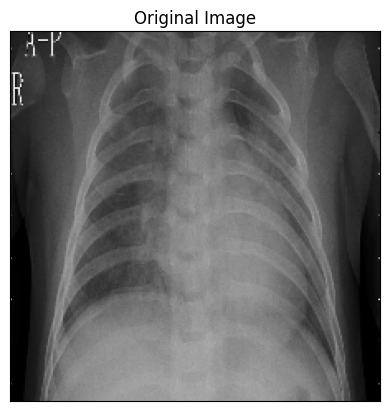

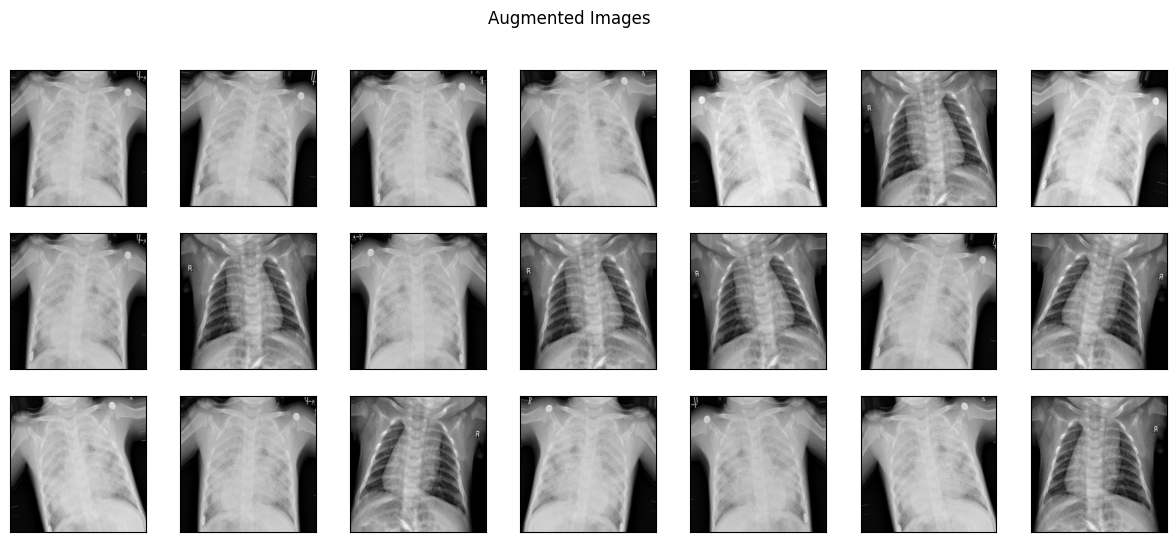

In [57]:
# Display original image
plt.imshow(x_train[1])  # Ensure x_train is defined
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

# Display augmented images
plt.figure(figsize=(15, 6))
i = 1

for img_name in os.listdir('preview_1/'):
    img_path = os.path.join('preview_1/', img_name)  # Correct path joining
    img = cv2.imread(img_path)

    if img is None:  # Check if image is loaded successfully
        print(f"Warning: Unable to read {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    i += 1
    if i > 3 * 7:  # Limit to 21 images
        break

plt.suptitle('Augmented Images')
plt.show()

# Model Building

In [58]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
conv_base = MobileNetV2(
    include_top = False,
    input_shape = (224, 224, 3),
    weights = 'imagenet')

for layer in conv_base.layers:
  layer.trainable = True

In [59]:
# Extract features from the pre-trained model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
x = conv_base.output
x = GlobalAveragePooling2D()(x)  # Corrected GlobalAveragePooling2D import
# Fully connected layers
x = Dense(units=512, activation='relu')(x)  # Fixed 'actication' typo
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)  # Fixed 'actication' typo
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)  # Fixed 'actication' typo
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)  # Fixed 'actication' typo
x = Dropout(rate=0.3)(x)
# Output layer for 3-class classification
predictions = Dense(3, activation='softmax')(x)  # Fixed 'Activation' parameter
# Define the final model
model = Model(conv_base.input, predictions)
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,989,955 (11.41 MB)

 Trainable params: 2,955,843 (11.28 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [65]:
callbacks = [ModelCheckpoint('.mdl_wts_mobilenetv2.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [61]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
BS = 16
print("[INFO] training head..")
H = model.fit(
    trainAug.flow(x_train, y_train, batch_size = BS),
    steps_per_epoch = train_len // BS,
    validation_data = (x_test, y_test),
    validation_steps = test_len // BS,
    epochs = 50,
    callbacks = callbacks
)

[INFO] training head..
Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4039 - loss: 1.2718
Epoch 1: val_loss improved from inf to 0.96956, saving model to .mdl_wts_mobilenetv2.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 84s 335ms/step - accuracy: 0.4050 - loss: 1.2701 - val_accuracy: 0.5913 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 2/50
 1/91 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - accuracy: 0.8750 - loss: 0.6197
Epoch 2: val_loss improved from 0.96956 to 0.96860, saving model to .mdl_wts_mobilenetv2.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8750 - loss: 0.6197 - val_accuracy: 0.5613 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8134 - loss: 0.5491
Epoch 3: val_loss did not improve from 0.96860
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step - accuracy: 0.8135 - loss: 0.5488 - val_accuracy: 0.2943 - val_loss: 13.7581 - learning_rate: 0.0010
Epoch 4/50
 1/91 ━━━━━━━━━━━━━━━━━━━━ 34s 388ms/step - accur

# Plot Model Performance

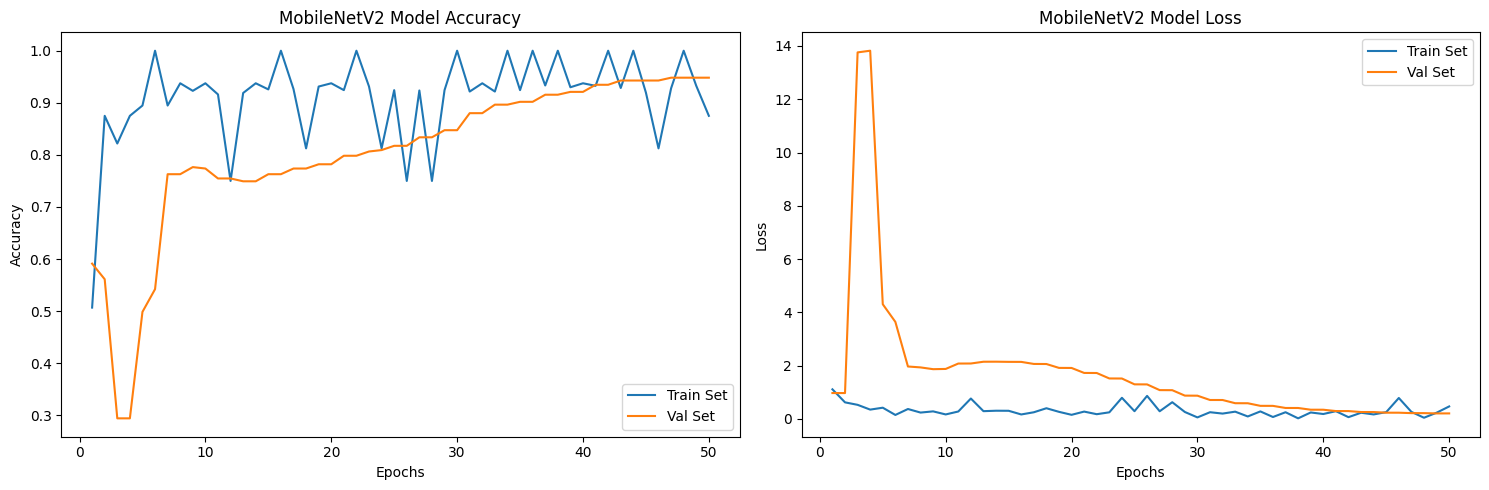

In [66]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs_range = range(1, len(H.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNetV2 Model Loss')
plt.tight_layout()
plt.show()


# Loading Best Model

In [67]:
model = load_model('.mdl_wts_mobilenetv2.keras')
model.save('/content/drive/My Drive/model_v1.h5')
model = load_model('/content/drive/My Drive/model_v1.h5')
# checking the accuracy
accuracy = model.evaluate(x_test, y_test, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9467 - loss: 0.1898

 Test_Accuracy:- 0.9482288956642151


# Confusion matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step


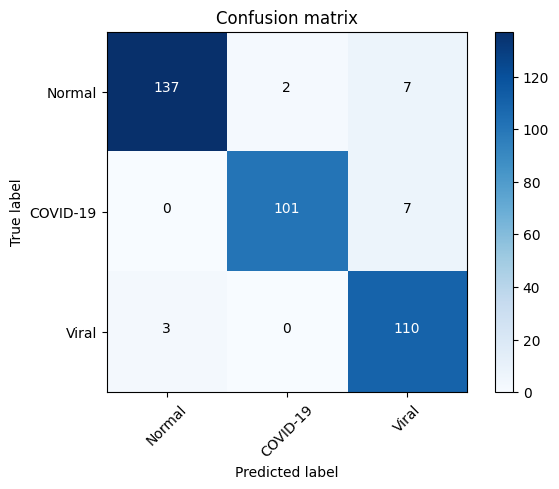

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    target_names =['Normal','COVID-19','Viral']
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Predict the values from the validation dataset
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

# Classification report

In [70]:
predIdxs = model.predict(x_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names = ['Normal', 'COVID-19', 'Viral']))

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96       146
    COVID-19       0.98      0.94      0.96       108
       Viral       0.89      0.97      0.93       113

    accuracy                           0.95       367
   macro avg       0.95      0.95      0.95       367
weighted avg       0.95      0.95      0.95       367



23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


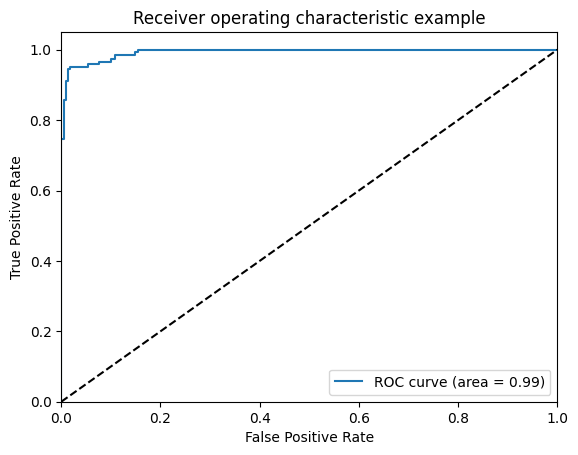

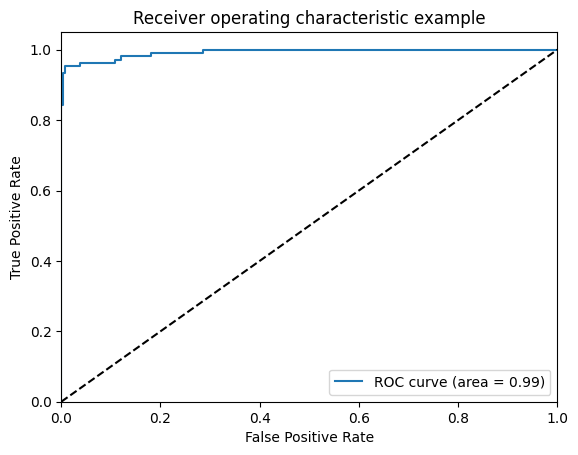

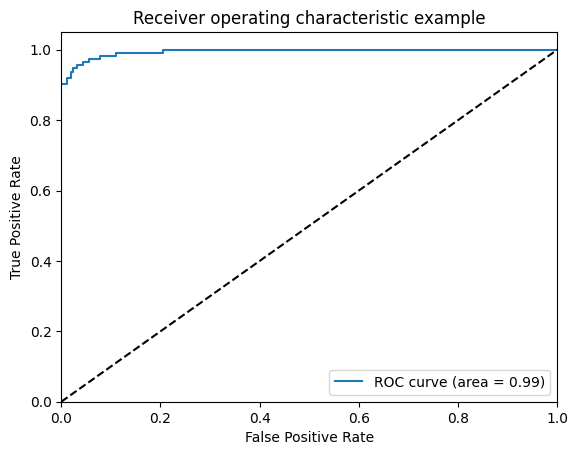

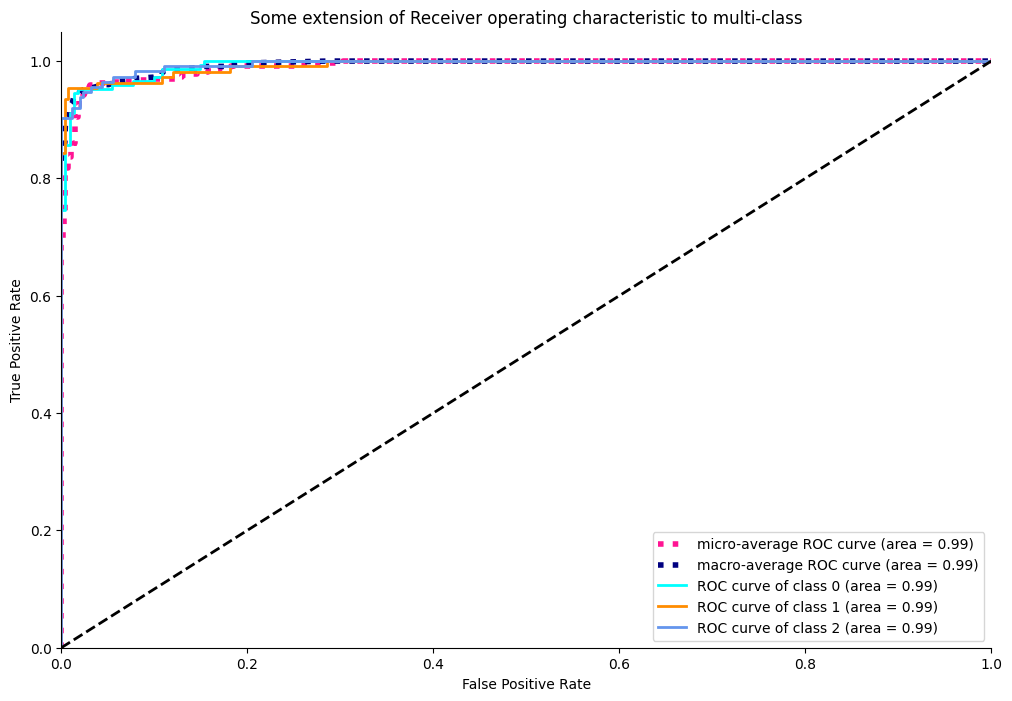

In [72]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from numpy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_test = np.array(y_test)
n_classes = 3
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

# Sample Predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


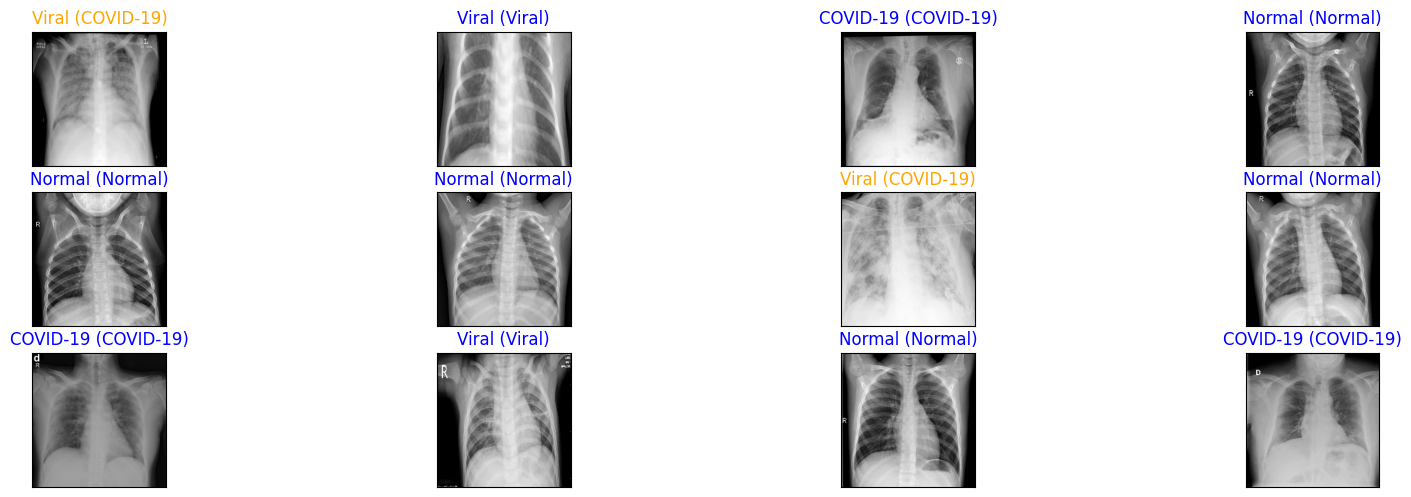

In [73]:
y_hat = model.predict(x_test)
# define text labels
cxr_labels = ['Normal', 'COVID-19', 'Viral']
# plot random samples of images, their predicted labels and ground_truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
  ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_test[idx]))
  pred_idx = np.argmax(y_hat[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(cxr_labels[pred_idx], cxr_labels[true_idx]),
               color=("blue" if pred_idx == true_idx else "orange"))

# Model Interpretation GRAD-CAM

In [74]:
import tensorflow as tf
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [75]:
# prepare image
img_size = (224, 224)
image = cv2.imread("/content/drive/My Drive/covid/38_A.jpg")
imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
image = cv2.resize(img, (224, 224))
# preprocessing the image
img = np.array(image)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255
# remove last layers softmax
model.layers[-1].activation = None
# print what top predict class is
preds = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


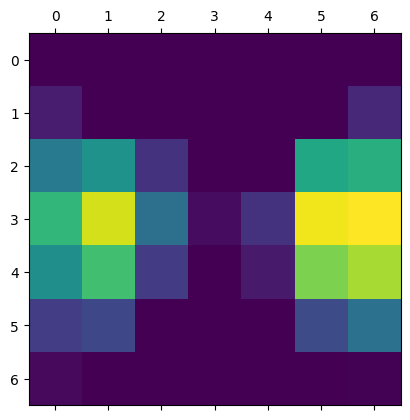

In [78]:
# Generate class activation heatmap
last_conv_layer_name = "block_16_depthwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

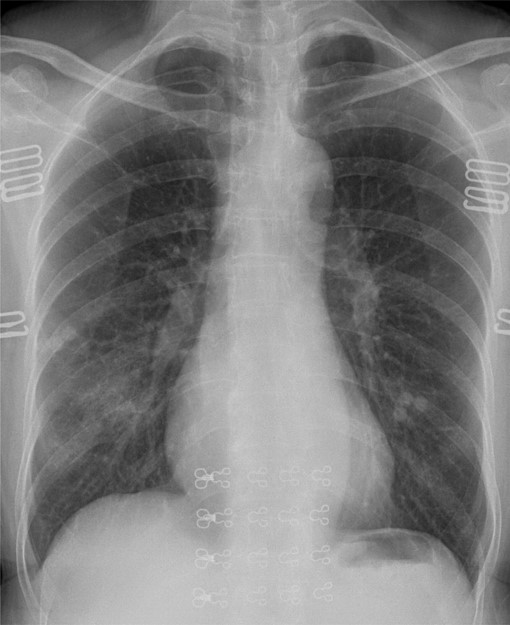

In [80]:
from IPython.display import Image, display
img_path1 ="/content/drive/MyDrive/covid/38_A.jpg"
display(Image(img_path1))

In [84]:
def wb(channel, perc = 0.05):
  mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100.0-perc))
  channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
  return channel

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    """Applies the Grad-CAM heatmap to the original image and displays it."""

    # Read the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap (jet) for visualization
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend the heatmap with the image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

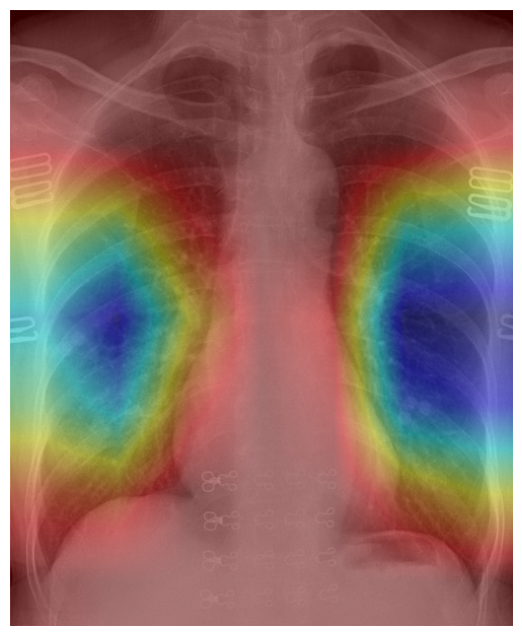

In [91]:
image = cv2.imread(img_path1)
imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
image = cv2.resize(img, (224, 224))
# Preprocessing the image
img = np.array(image)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255
last_conv_layer_name = "block_16_depthwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
save_and_display_gradcam(img_path1, heatmap)